In [1]:
import os
import docvision as dv
import docgenpipe as dg

In [2]:
cd ..

/Users/asukh/Work/VSCode/Python/ucu-mt


/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
data = dg.read_jsonl("dataset/metadata.jsonl")

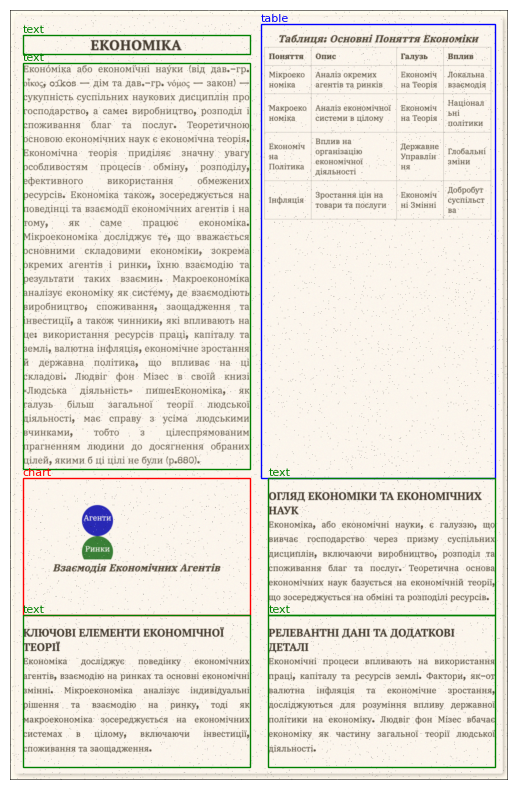

In [13]:
doc = data[-5]
dv.visualize_grounding(doc["png_path"], doc["grounding"])